In [4]:
# Imports
from randomWalkMC import random_walk_mc, jacc_random_walk_mc
from baselines import *
import json
from recommenders import *
import numpy as np
import random
from tqdm.notebook import tqdm
from common import DATA
import scipy.stats as stats
import matplotlib.pyplot as plt
from time import time
from utils import *

# Define our algorithms

In [5]:
algorithms = {
    'Random': random_recommender,
    'Universal Random': universal_recommender,
    'Mode of Neighbours': mode_of_neighbours,
    'Mean of Neighbours': mean_of_neighbours,
    'Median of Neighbours': median_of_neighbours,
    'Jaccard Weighted Neighbours': jaccard_weighted_neighbours,
    'Jaccard Monte-Carlo Random Walk': jacc_random_walk_mc,
    'Monte-Carlo Random Walk': random_walk_mc,
    'Jaccard MoM': jaccard_majority_of_majorities,
    'Jaccard WA': jaccard_weighted_majorities,
    'Item-Jaccard WA': intra_item_WA_pearson,
    'Item-Rating Difference WA': item_diff_recommender,
    'Intra-Item WA': intra_item_WA_jacc,
    'Jaccard Intra-Item WA': jaccard_intra_item_jii,
    'WIRD WA': jii_weighted_item_diffs,
    'JWIRD WA': jaccard_weighted_item_diffs,
    'Jaccard Item-Jaccard WA': jaccard_item_jaccard(alpha=0.5),
    'Jaccard Item-Jaccard JII Combination WA': jaccard_item_jaccard_JII,
    'Intra-Item WA (Pearson)': item_jaccard_recommender_WA,
}

# Evaluation

In [11]:
# Fetch cached results that have been precomputed
with open('./results.json', 'r') as infile:
    results = json.load(infile)
    
# Uncomment to recompute results
# results = {}

In [ ]:
for k, recommender in algorithms.items():
    if k in results:
        continue
    sample_sizes, accs, mses, mes, timing = [], [], [], [], []
    # for d in DATA.values(): 
    d = DATA['epinions'] # Specify the dataset to use
    for i in tqdm(d['items'][:5]): # Top 5 items
        for _ in range(10): # run 10 times for each item
            before_time = time()
            acc, mse, me = evaluate(recommender, d, i, 0.15) # remove 15% of ratings
            accs.append(acc), mses.append(mse), mes.append(me), timing.append(time() - before_time)

    results[k] = {
        'sample_sizes': sample_sizes,
        'acc': accs,
        'mse': mses,
        'me': mes,
        'timing': timing,
    }

In [16]:
# Uncomment to dump results to file
# with open('results.json', 'w+') as outfile:
#     json.dump(results, outfile)

# Visualisation

In [ ]:
# Define set of colours for the recommendation systems
import colorsys
N = len(results)
HSV_tuples = [(x*1.0/N, 0.85, 0.7) for x in range(N)]
RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
random.shuffle(RGB_tuples)

fig = plt.figure(figsize=(10, 6))

keep_algs = list(results.keys())
# Enter the specifc algorithm names we want to plot the results of
# keep_algs = [
#     'Random',
#     'Universal Random',
#     'Item-Jaccard WA',
#     'Intra-Item WA',
#     'Intra-Item WA (Pearson)',
# ]

result_items = sorted(list([(a, v) for a, v in results.items(
) if a in keep_algs]), key=lambda x: np.mean(x[1]['mse']))

plt.xlim(0, 2.5)
plt.title("MAE Distributions")
names, mae, std = [], [], []
for i, (name, res) in enumerate(result_items):
    mu = np.mean(res['me'])
    sigma = np.std(res['me'])
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label=name, color=RGB_tuples[i])
    names.append(name)
    mae.append(mu)
    std.append(sigma)

nms = list(zip(names, mae, std))
nms.sort(key=lambda x: (x[1], x[2]))

for name, m, s in nms:
    min_mae = round(m, 2) == round(min(mae), 2)
    min_s = round(s, 2) == round(min(std), 2)
    text_bf = '\\textbf{'
    print(f"{name} & {text_bf if min_mae else ''}{m:.2f}{'}' if min_mae else ''} & {text_bf if min_s else ''}{s:.2f}{'}' if min_s else ''} \\\\")
plt.legend( loc='upper right')
plt.ylabel("PDF")
plt.xlabel("MAE")
plt.show()


# Adversarial Testing

In [100]:
adversarial_results = {}

In [ ]:
# Select algorithms we want to test
adversarial_algorithms = [
    'Jaccard WA',
    'Jaccard Monte-Carlo Random Walk',
    'Item-Jaccard WA',
    'WIRD WA',
    'Jaccard Item-Jaccard WA',
    'Jaccard Item-Jaccard JII Combination WA',
]

# Compute adversarial results
for k in adversarial_algorithms:
    recommender = algorithms[k]
    if k in adversarial_results:
        continue
    sample_sizes, accs, mses, mes, timing = [], [], [], [], []
    # for d in DATA.values():
    d = DATA['epinions_adversial']
    for i in tqdm(d['items'][:5]): 
        for _ in range(5): # run 5 times for each item
            before_time = time()
            acc, mse, me = evaluate(recommender, d, i, 0.15) # remove 15% of ratings
            accs.append(acc), mses.append(mse), mes.append(me), timing.append(time() - before_time)

    adversarial_results[k] = {
        'sample_sizes': sample_sizes,
        'acc': accs,
        'mse': mses,
        'me': mes,
        'timing': timing,
    }

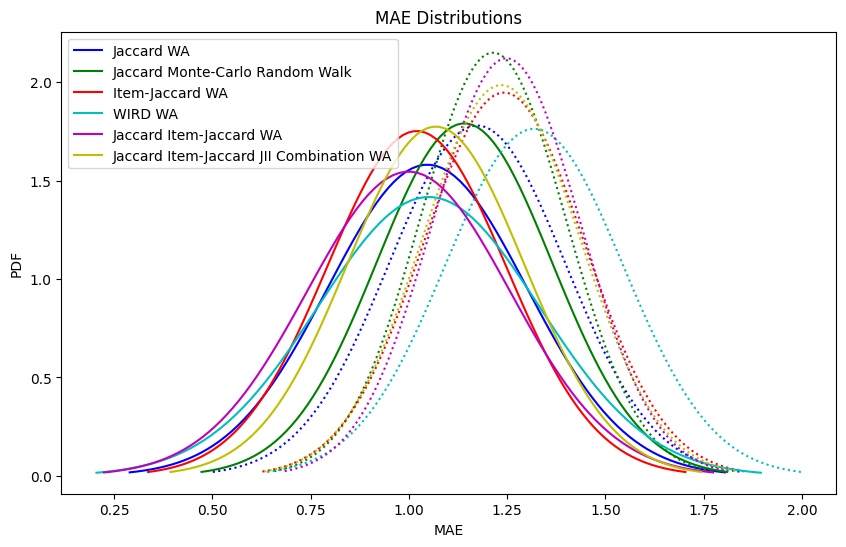

In [104]:
# Extract mean and standard deviation for each algorithm in normal and adversarial scenarios
normal_data = {alg: [np.mean(res['me']), np.std(res['me'])] for alg, res in results.items()}
adversarial_data = {alg: [np.mean(res['me']), np.std(res['me'])] for alg, res in adversarial_results.items()}

# Generate some colors
colors = ['b', 'g', 'r', 'c', 'm', 'y']

fig, ax = plt.figure(figsize=(10, 6)), plt.gca()

for i, alg in enumerate(adversarial_results.keys()):
    # Extracting mu and sigma for both normal and adversarial data
    mu, sigma = normal_data[alg]
    mu_adv, sigma_adv = adversarial_data.get(alg, (None, None)) # Using get to avoid KeyError
    
    # Creating a range for x-axis based on the mu and sigma
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    
    # Plotting the normal data
    ax.plot(x, stats.norm.pdf(x, mu, sigma), label=alg, color=colors[i])
    
    # Check if there is adversarial data for the algorithm
    if mu_adv is not None and sigma_adv is not None:
        # Creating a range for x-axis based on the mu_adv and sigma_adv
        x_adv = np.linspace(mu_adv - 3*sigma_adv, mu_adv + 3*sigma_adv, 100)
        # Plotting the adversarial data with dotted lines
        ax.plot(x_adv, stats.norm.pdf(x_adv, mu_adv, sigma_adv), linestyle='dotted', color=colors[i])

# Adding legend and labels
ax.legend()
plt.ylabel("PDF")
plt.xlabel("MAE")
plt.title("MAE Distributions")

# Adding custom legend/label for solid and dotted lines
handles, labels = ax.get_legend_handles_labels()
solid_line = plt.Line2D([0], [0], color='black', linewidth=1.5, linestyle='-')
dotted_line = plt.Line2D([0], [0], color='black', linewidth=1.5, linestyle=':')
plt.legend([solid_line, dotted_line], ['Normal', 'Adversarial'], loc='upper right')

# Returning original legend
ax.legend(handles, labels, loc='upper left')

plt.show()

In [105]:
# Print results to be copied into latex table
for i, alg in enumerate(adversarial_results.keys()):
    # Extracting mu and sigma for both normal and adversarial data
    mu, sigma = normal_data[alg]
    mu_adv, sigma_adv = adversarial_data.get(alg, (None, None)) # Using get to avoid KeyError
    print(f"{alg} & {mu:.2f} & {sigma:.2f} & {mu_adv:.2f} & {sigma_adv:.2f} & {((mu_adv - mu)/mu)*100 : .2f} \\\\")

Jaccard WA & 1.05 & 0.25 & 1.17 & 0.22 &  12.12 \\
Jaccard Monte-Carlo Random Walk & 1.14 & 0.22 & 1.21 & 0.19 &  6.39 \\
Item-Jaccard WA & 1.02 & 0.23 & 1.24 & 0.20 &  21.77 \\
WIRD WA & 1.05 & 0.28 & 1.32 & 0.23 &  25.53 \\
Jaccard Item-Jaccard WA & 1.00 & 0.26 & 1.25 & 0.19 &  24.93 \\
Jaccard Item-Jaccard JII Combination WA & 1.07 & 0.22 & 1.23 & 0.20 &  15.58 \\
